  

<span style="font-family:Avenir; font-size:3em;">Prescriptive DELPHI</span>

<span style="font-family:Avenir; font-size:2em;">J. K. Ivanhoe, A. Previero</span>
- - - -

In [1]:
import os
import logging

# Data dependencies
import numpy as np
import pandas as pd

# Plotting dependencies
import us
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from copy import deepcopy

In [2]:
os.getcwd()

'/Users/joshivanhoe/Dropbox (MIT)/COVID-19'

In [3]:
# Specify repo folder
#os.chdir("/Users/alessandropreviero/PycharmProjects/optimal-vaccine-allocation/src") # Ale
os.chdir("../../Documents/GitHub/optimal-vaccine-allocation/src") # Josh

In [4]:
%load_ext autoreload
%autoreload 2

from models.delphi import DiscreteDELPHISolution, PrescriptiveDELPHIModel
from utils.data_processing import get_initial_conditions, get_delphi_params, get_vaccine_params

# Data processing

In [5]:
# Specify data folder
#folder = "/Users/alessandropreviero/Dropbox/COVID-19/processed-data/" # Ale
folder = "../../../../Dropbox (MIT)/COVID-19/processed-data" # Josh

# Load data
pop_df = pd.read_csv(f"{folder}/population.csv").sort_values("state")
param_df = pd.read_csv(f"{folder}/params.csv", index_col=0).sort_index()
mortality_df = pd.read_csv(f"{folder}/mortality-rates.csv", index_col=0)

In [68]:
# Set epidemilogical parameters
detection_prob = 0.2
hospitalization_prob = 0.15
median_progression_time = 5
median_detection_time = 2
median_death_time = 15
median_recovery_time = 15

# Set time discretization
n_days = 60
days_per_timestep = 1
planning_period = 1

# Define risk classes
risk_classes = [
    dict(sexes=["M", "F"], min_age=0, max_age=4),
    dict(sexes=["M", "F"], min_age=5, max_age=54),
    dict(sexes=["M", "F"], min_age=55, max_age=64),
    dict(sexes=["M", "F"], min_age=65, max_age=74),
    dict(sexes=["M", "F"], min_age=75, max_age=84),
    dict(sexes=["M", "F"], min_age=85, max_age=np.inf)
]

# Set vaccination params (remaining params are set after the vaccine_budget is specified)
optimize_capacity=False
excluded_risk_classes = [0, 5]

# Set plannning scenarios
scenarios = [
    dict(vaccine_budget_pct = budget, vaccine_effectiveness = efficacy) 
    for efficacy in np.linspace(0.3, 0.7, 5)
    for budget in np.linspace(1e-4, 1e-3, 4)
]

single_scenario = [
    dict(
        vaccine_effectiveness = 0.6,
        vaccine_budget_pct=1e-3,
        max_allocation_pct=5e-3,
        min_allocation_pct=2e-4,
        max_decrease_pct=0.1,
        max_increase_pct=0.5
    )
]

# Experimentation

In [69]:
n_regions = pop_df["state"].nunique()
n_risk_classes = len(risk_classes)
n_timesteps = int(round(n_days / days_per_timestep))
total_pop = pop_df["population"].sum() / 1e2

results = []
print(f"Running {len(single_scenario)} experiments...")

for scenario in single_scenario:
    
    print(f"\nRunning scenario with vaccine budget of {scenario['vaccine_budget_pct']*100}%, and " 
          f"vaccine efficacy at {scenario['vaccine_effectiveness']*100}%")

    initial_conditions = get_initial_conditions(
        pop_df=pop_df, 
        param_df=param_df, 
        risk_classes=risk_classes, 
        n_regions=n_regions, 
        detection_prob=detection_prob
    )

    delphi_params = get_delphi_params(
        pop_df=pop_df, 
        param_df=param_df, 
        mortality_df=mortality_df, 
        risk_classes=risk_classes,
        n_regions=n_regions, 
        n_timesteps=n_timesteps, 
        detection_prob=detection_prob,
        hospitalization_prob=hospitalization_prob,
        median_progression_time=median_progression_time,
        median_detection_time=median_detection_time,
        median_death_time=median_death_time,
        median_recovery_time=median_recovery_time,
        days_per_timestep=days_per_timestep
    )

    vaccine_params = get_vaccine_params(
        n_timesteps=n_timesteps,
        total_pop=total_pop,
        vaccine_budget_pct=scenario['vaccine_budget_pct'],
        vaccine_effectiveness=scenario['vaccine_effectiveness'],
        max_allocation_pct=scenario['max_allocation_pct'] ,
        min_allocation_pct=scenario['min_allocation_pct'],
        max_total_capacity_pct=scenario['vaccine_budget_pct'],
        max_decrease_pct=scenario["max_decrease_pct"],
        max_increase_pct=scenario["max_increase_pct"],
        optimize_capacity=optimize_capacity,
        excluded_risk_classes=excluded_risk_classes,
        planning_period=planning_period
    )

    # Load model, compute baseline, and run coordinate descent
    model = PrescriptiveDELPHIModel(
    initial_conditions=initial_conditions, 
    delphi_params=delphi_params,
    vaccine_params=vaccine_params
    )
    
    baseline = model.simulate()
    print(f"Baseline objective: {'{0:.2f}'.format(baseline.get_objective())}")
    
    solution, _ = model.solve(
        exploration_rel_tol=0.2,
        exploration_abs_tol=5,
        termination_tol=1e-2,
        n_restarts=1,
        max_iterations=5,
        disable_crossover=True,
        output_flag=False,
        log=True)
    
    # Store results
    results.append(
        {
            "Vaccine budget": scenario["vaccine_budget_pct"],
            "vaccine efficacy": scenario["vaccine_effectiveness"],
            "Baseline objective": baseline.get_objective(), 
            "Solution objective": solution.get_objective(), 
            "Total population": solution.population.sum(),
            "solution": solution,
            "model": model,
        }
    )
    

results = pd.DataFrame(results)
results["Improvement %"] = (results["Baseline objective"] - results["Solution objective"]) \
    / results["Baseline objective"] * 100
results["Baseline deaths %"] = results["Baseline objective"] / results["Total population"] * 100
results["Solution deaths %"] = results["Solution objective"] / results["Total population"] * 100

Running 1 experiments...

Running scenario with vaccine budget of 0.1%, and vaccine efficacy at 60.0%
Baseline objective: 729.97
Restart: 1/1
Iteration: 0/5 	 Objective value: 706.81
Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Crossover to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Iteration: 1/5 	 Objective value: 633.19
Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Crossover to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Infeasible relaxation - terminating search


In [70]:
table = results.drop(["solution", "model"], axis=1)
table

,Vaccine budget,vaccine efficacy,Baseline objective,Solution objective,Total population,Improvement %,Baseline deaths %,Solution deaths %
0,0.001,0.6,729.970947,633.194316,3271674.34,13.2576,0.022312,0.019354


- - - - 
## Results intepretation 

In [131]:
allocation = results.iloc[0]['solution'].vaccinated / 10
population = results.iloc[0]['solution'].population.sum(axis=1)
states = list(pop_df["state"].unique())
frames = np.linspace(0, 60, 61, dtype = int)

### *Visualize allocation policy in a single state across all risk classes*

In [132]:
to_display = 'California'
idx = states.index(to_display)

state_allocation = allocation[idx][:, frames].transpose() / 10
state_allocation = pd.DataFrame(state_allocation, 
                                columns=[str(cls['max_age']) for cls in risk_classes], 
                                index =[str(fr) for fr in frames] 
                               )
# simplify age groups
state_allocation['young'] = state_allocation['4'] + state_allocation['54']
state_allocation['adult'] = state_allocation['64'] + state_allocation['74']
state_allocation['old'] = state_allocation['84'] + state_allocation['inf']
state_allocation = state_allocation.drop(columns = ['4', '54', '64', '74', '84', 'inf'])

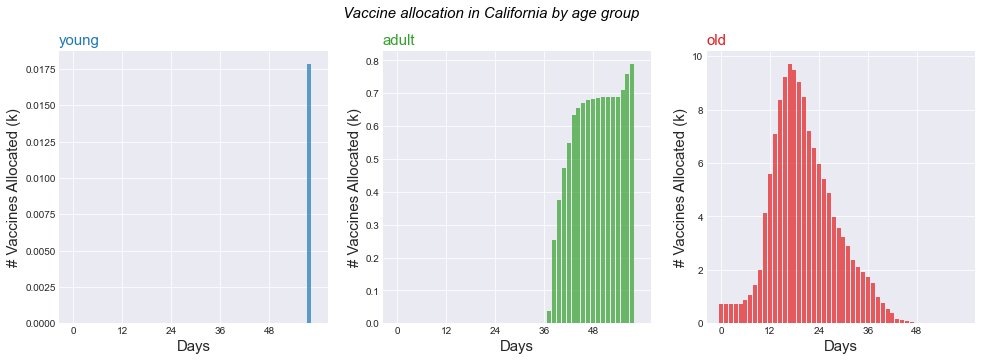

In [133]:
palette = plt.get_cmap('Paired')
plt.style.use('seaborn-darkgrid')

num = 0
fig = plt.figure(figsize = (14,5))
for col in state_allocation.columns:
    num += 1
    ax = plt.subplot(1, 3, num)
    plot_settings = dict(alpha = 0.7) #, linestyle="solid", marker="")
    plt.bar(state_allocation.index, state_allocation[col], color = palette(2*num -1), **plot_settings)
    
    plt.title(col, loc='left', fontsize=15, fontweight=0, color=palette(2*num -1) )

    plt.xlabel('Days', fontsize = 15)
    plt.ylabel('# Vaccines Allocated (k)', fontsize = 15)
    ax.set_xticks(state_allocation.index[::10])
    ax.set_xticklabels(state_allocation.index[::10])

fig.tight_layout(pad=2.0)
plt.suptitle(f"Vaccine allocation in {to_display} by age group", 
             fontsize=15, fontweight=0, color='black', style='italic', y = 1.02);



- **young** population: from 0 to 55 years old
- **adult** population: from 55 to 75 years old 
- **old** population: from 75 years old, onwards

**KEY TAKE-AWAY**: Vaccines are delivered to prioritize at-risk classes first.

- - - -

### *Visualize allocation policy across all states for all classes*

In [124]:
classes = {'young':[0,1], 'adult':[2,3], 'old':[4,5], 'all':np.arange(6)}
to_display = 'all'
class_allocation = allocation[:, classes[to_display], :].sum(axis =1)
class_allocation = pd.DataFrame(class_allocation, index = states, columns = [str(fr) for fr in frames] )

ValueError: Shape of passed values is (51, 61), indices imply (51, 50)

In [125]:
cumul_30days = class_allocation.iloc[:, 0:31].sum(axis =1)
ordered_states_30 = [x for _,x in sorted(zip(cumul_30days/population, cumul_30days.index), reverse=True)]
cumul_30days_capita = cumul_30days[ordered_states_30]

cumul_90days = class_allocation.sum(axis =1)
ordered_states_90 = [x for _,x in sorted(zip(cumul_90days/population, cumul_90days.index), reverse=True)]
cumul_90days_capita = cumul_90days[ordered_states_90]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

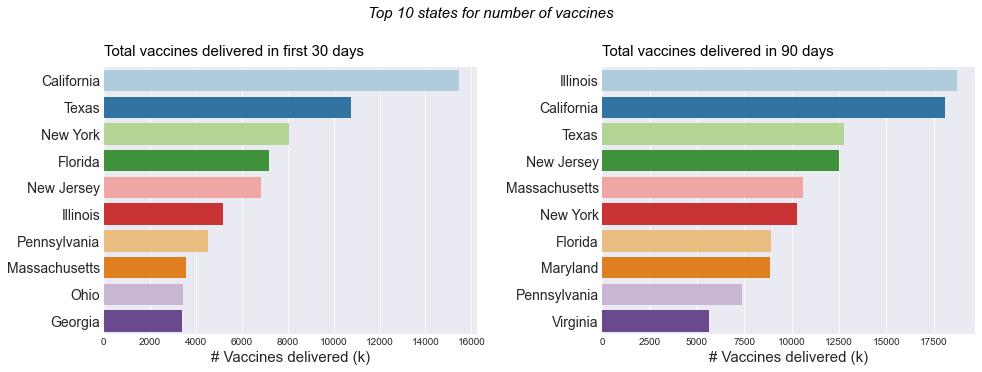

In [76]:
cumu_30 = cumul_30days.sort_values(ascending = False)
cumu_90 = cumul_90days.sort_values(ascending = False)

fig = plt.figure(figsize = (14,5))
ax = plt.subplot(1, 2, 1)

sns.barplot(x = cumu_30.values[0:10], y = cumu_30.index[0:10], orient = 'h', palette = 'Paired')
plt.xlabel("# Vaccines delivered (k)", fontsize = 15)
plt.title('Total vaccines delivered in first 30 days', loc='left', fontsize=15, fontweight=0, 
          color='black', y = 1.02 )
ax.set_yticklabels(labels=cumu_30.index[0:10], fontsize=14);

ax = plt.subplot(1,2, 2)
sns.barplot(x = cumu_90.values[0:10],
            y = cumu_90.index[0:10],
            orient = 'h',
            palette = 'Paired')
plt.title('Total vaccines delivered in 90 days', loc='left', fontsize=15, fontweight=0, color='black',  y = 1.02)
plt.xlabel("# Vaccines delivered (k)", fontsize = 15)
ax.set_yticklabels(labels =cumu_90.index[0:10], fontsize=14);

plt.suptitle(f"Top 10 states for number of vaccines", 
             fontsize=15, fontweight=0, color='black', style='italic', y = 1.05);

fig.tight_layout(pad=2.0)

**KEY TAKE-AWAY**: short-term and long-term allocations vary significantly - to consider the *vulnerability* of each state

- - - - 

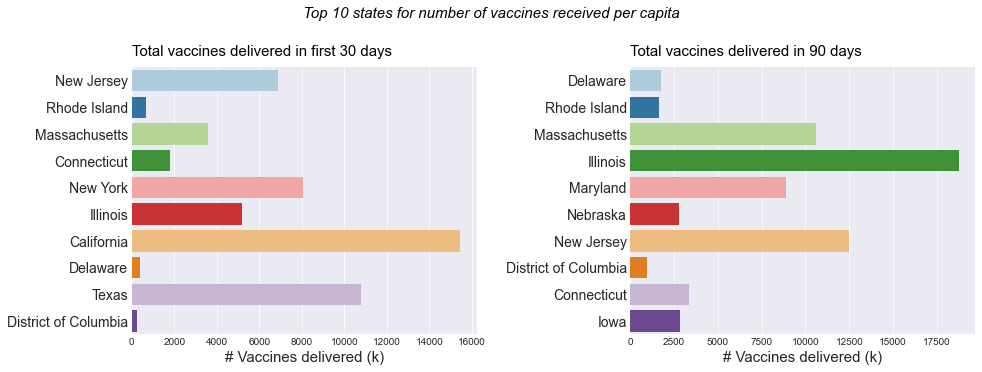

In [77]:
fig = plt.figure(figsize = (14,5))
ax = plt.subplot(1, 2, 1)

sns.barplot(x = cumul_30days_capita.values[0:10], 
            y = cumul_30days_capita.index[0:10], 
            orient = 'h', 
            palette = 'Paired')

plt.xlabel("# Vaccines delivered (k)", fontsize = 15)
plt.title('Total vaccines delivered in first 30 days', loc='left', fontsize=15, 
          fontweight=0, color='black', y = 1.02 )
ax.set_yticklabels(labels = cumul_30days_capita.index[0:10], fontsize=14);

ax = plt.subplot(1,2, 2)
sns.barplot(x = cumul_90days_capita.values[0:10],
            y = cumul_90days_capita.index[0:10],
            orient = 'h',
            palette = 'Paired')

plt.xlabel("# Vaccines delivered (k)", fontsize = 15)
plt.title('Total vaccines delivered in 90 days', loc='left', fontsize=15, fontweight=0, color='black',  y = 1.02)
ax.set_yticklabels(labels=cumul_90days_capita.index[0:10], fontsize=14);


plt.suptitle(f"Top 10 states for number of vaccines received per capita", 
             fontsize=15, fontweight=0, color='black', style='italic', y = 1.05);

fig.tight_layout(pad=2.0)

**KEY TAKE-AWAY**: to be added

- - - - 

### Visualizing across multiple states for each risk class

In [95]:
smooth_solution = model.simulate(
    vaccinated=model._smooth_vaccine_allocation(solution.vaccinated, smoothing_window=1)
)

In [102]:
solution.get_objective()
smooth_solution.get_objective()

624.4037830819988

In [96]:
palette = plt.get_cmap('Dark2')
to_display = 'old'
num_states = 9
class_allocation = smooth_solution.vaccinated.sum(axis =1)
class_allocation = pd.DataFrame(class_allocation, index = states, columns = [fr for fr in frames] )

top_states_capita = class_allocation.loc[cumul_90days_capita.index[0:num_states]].transpose()

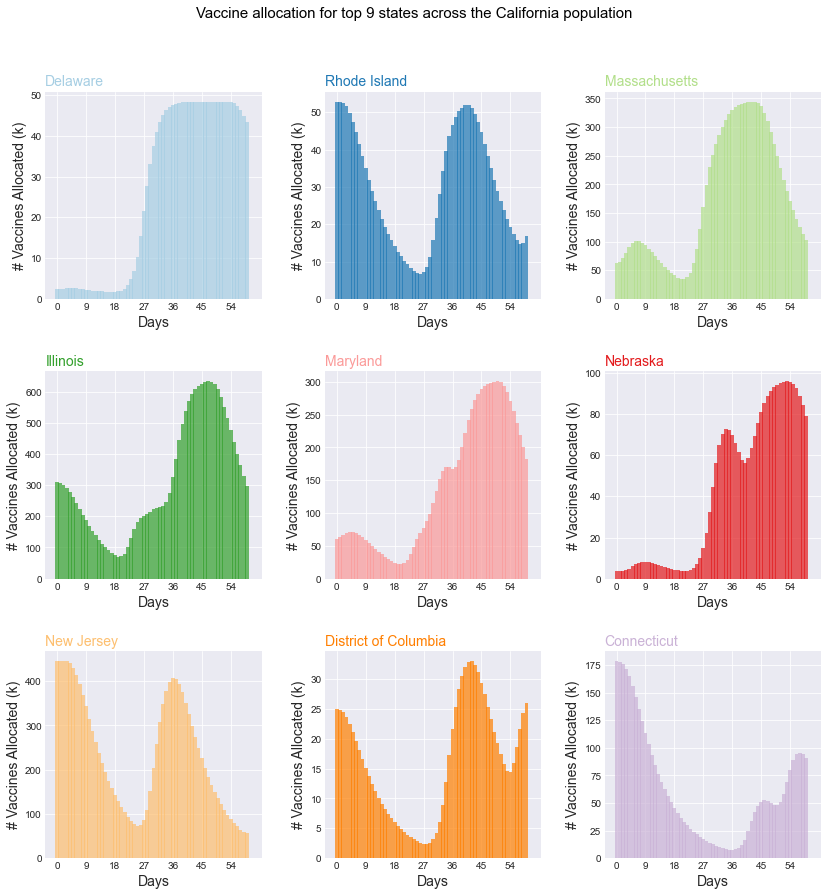

In [120]:
num = 0
fig = plt.figure(figsize=(12, 12))
for col in top_states_capita.columns:
    num += 1
    ax = plt.subplot(3,3, num)
    plot_set = dict(alpha = 0.7, width=1.2) #, linestyle="solid", marker="o")
    plt.bar(top_states_capita.index, top_states_capita[col], color = palette(num-1), **plot_set)
    
    plt.title(col, loc='left', fontsize=14, fontweight=0, color=palette(num -1) )

    plt.xlabel('Days', fontsize = 14)
    plt.ylabel('# Vaccines Allocated (k)', fontsize = 14)
    ax.set_xticks(top_states_capita.index[::num_states])
    ax.set_xticklabels(top_states_capita.index[::num_states])

fig.tight_layout(pad=2.5)
plt.suptitle(f"Vaccine allocation for top {num_states} states across the {to_display} population", 
             fontsize=15, fontweight=0, color='black', y =1.05 );

**KEY TAKE-AWAY**: for all age groups, the optimization method seems to pick a subset of *optimal policies*
- - - -

## Plotting results from simulations

In [ ]:
table_results = pd.read_csv("/Users/alessandropreviero/Dropbox/COVID-19/results_prescriptive_delphi_v2.csv")
table_results.vaccine_budget_pct = table_results.vaccine_budget_pct*100
table_results.vaccine_budget_pct = table_results.vaccine_budget_pct.astype("category")

table_results.vaccine_efficacy = table_results.vaccine_efficacy*100
table_results.vaccine_efficacy = table_results.vaccine_efficacy.astype("category")

In [ ]:
sns.set(rc={'figure.figsize':(7.5,6)})
ax = sns.lineplot(x="vaccine_budget_pct", 
             y="pct_improvement", 
             hue ="vaccine_efficacy", 
             data = table_results, 
             palette = "Paired")
ax.set(xlabel="Per-day vaccine budget (% US Population)", ylabel="Objective improvement (%)")
plt.legend(title="Vaccine Efficacy, %", labels = [30, 40, 50, 60, 70, 100])

In [ ]:
sns.set(rc={'figure.figsize':(7.5,6)})
ax = sns.lineplot(x="vaccine_efficacy", 
             y="pct_improvement", 
             hue ="vaccine_budget_pct", 
             data = table_results, 
             palette = "Paired")
ax.set(xlabel="Vaccine Efficacy (%)", ylabel="Objective improvement (%)")
plt.legend(title="Per-day vaccine budget, %", labels = [0.01, 0.03, 0.05, 0.1])

In [ ]:
solution = results.iloc[0]["solution"]
solution.plot()

In [ ]:
solution = results.iloc[0]["solution"]
model = results.iloc[0]["model"]
map_animation(solution, model, exclude_low_risk_class=False, duration=250)

In [ ]:
scatter_animation(solution, model, exclude_low_risk_class=False, duration=100)

$\text{Risk score}_{jk}^{(t)} = \left(\alpha_{j}\gamma_{j}^{(t)}\delta_k S_{jk}^{(t)}\left[\sum_{l=1}^K \left(E_{jl}^{(t)} + I_{jl}^{(t)}\right)\right] / \left(N_{jk} \sum_{l=1}^K N_{jl}\right)\right)^\omega$

## Animations

In [ ]:
def scatter_animation(
    solution: DiscreteDELPHISolution,
    model: PrescriptiveDELPHIModel,
    exclude_low_risk_class = False,
    duration = 1500,
    omega = 0.5
) -> go.Figure:
    
    # Get dimensions
    n_regions, n_risk_classes, n_timesteps = solution.susceptible.shape
    planning_timesteps = [t for t in range(n_timesteps - 1) if model.vaccine_budget[t] > 0]
    risk_classes = np.argsort(-model.mortality_rate)[:-1] if exclude_low_risk_class else np.arange(n_risk_classes)
    
    #Get state abbreviations
    states = [state.name for state in us.states.STATES]
    states.append("District of Columbia")
    states = sorted(states)
    state_abbrs = list(map(lambda state: us.states.lookup(state).abbr, states))
    
    # Get data
    data = pd.DataFrame(
        [
            {
                "Day": t * solution.days_per_timestep,
                "State": state_abbrs[j],
                "Mortality rate (%)": model.mortality_rate[k] * 100,
                "Mortality rate": f"{'{0:.2f}'.format(model.mortality_rate[k] * 100)}%",
                "Susceptible population":  f"{'{0:.0f}'.format(solution.susceptible[j, k, t])}k",
                "Risk score": model.mortality_rate[k] * solution.susceptible[j, k, t] \
                    * model.infection_rate[j] * model.policy_response[j, t]
                    * (solution.infectious[j, :, t] + solution.exposed[j, :, t]).sum() \
                    / solution.population[j, :].sum() /  solution.population[j, k],
                "Total vaccinated (%)": solution.vaccinated[j, k, 0:t].sum() / \
                    solution.population[j, k] * 1e2,
                "Size": np.sqrt(solution.population[j, k])
            }
            for j in range(n_regions) for k in risk_classes for t in planning_timesteps
        ]
    )
    risk_score_cap = data["Risk score"].quantile(1-1e-4)
    data["Risk score"] = data["Risk score"].where(data["Risk score"] < risk_score_cap, risk_score_cap)
    data["Normalized risk score"] = (data["Risk score"] / risk_score_cap) ** omega * 100
    
    # Create plot
    fig = px.scatter(
        data,
        x="Normalized risk score",
        y="Total vaccinated (%)",
        size="Size",
        color="Mortality rate (%)",
        color_continuous_scale=["#636EFA", "#EF553B"],
        animation_frame="Day",
        title="Vaccine allocation by population subset",
        range_y=(-10, 110),
        hover_data={
            col: col in ["State", "Mortality rate", "Susceptible population"] for col in data.columns
        }
    )
    fig.update_traces(marker_line_width=0)
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = duration
    return fig

In [ ]:
def map_animation(
    solution: DiscreteDELPHISolution,
    model: PrescriptiveDELPHIModel,
    exclude_low_risk_class = False,
    duration = 500
) -> go.Figure:
    
    # Get dimensions
    n_regions, n_risk_classes, n_timesteps = solution.susceptible.shape
    planning_timesteps = [t for t in range(n_timesteps - 1) if model.vaccine_budget[t] > 0]
    risk_classes = np.argsort(-model.mortality_rate)[:-1] if exclude_low_risk_class else np.arange(n_risk_classes)
    
    # Get state abbreviations
    states = [state.name for state in us.states.STATES]
    states.append("District of Columbia")
    states = sorted(states)
    state_abbrs = list(map(lambda state: us.states.lookup(state).abbr, states))
    
    # Format data
    data = pd.DataFrame(
        [
            {
                "Day": t * solution.days_per_timestep,
                "State": state_abbrs[j],
                "Total vaccinated (%)": solution.vaccinated[j, risk_classes, 0:t+1].sum() \
                    / solution.population[j, risk_classes].sum() * 100,
                "Total deaths": f"{'{0:.0f}'.format(solution.deceased[j, :, t].sum() * 1e3)}"
            }
            for j in range(n_regions) for t in planning_timesteps
        ]
    )
    data["Total vaccinated"] = data["Total vaccinated (%)"].apply(
        lambda x: f"{'{0:.1f}'.format(x)}%"
    )
    
    # Create figure
    fig = px.choropleth(
        data,
        locationmode="USA-states",
        locations="State",
        color="Total vaccinated (%)",
        animation_frame="Day",
        range_color=(0, 20),
        color_continuous_scale=["#FFFFFF", "#123570"],
        hover_name = "State",
        hover_data = {col: col in ["Total vaccinated", "Total deaths"] for col in data.columns}
    )
    
    # Update layout
    fig.update_layout(
        title_text="Vaccine allocation by state",
        geo_scope="usa"
    )
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = duration
    return fig